# Instant Market Basket Analysis

In [4]:
%matplotlib inline

from wordcloud import *
import textblob
import numpy as np
from nltk import tokenize
from nltk.corpus import stopwords
from collections import Counter
import random
import string
import operator
import re
import pandas as pd
import math
import os
import networkx as nx
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import psycopg2
import seaborn as sbn
import requests
import textatistic
from IPython.display import display, Markdown
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
py.offline.init_notebook_mode()

In [5]:
orders = pd.read_csv('/home/faculty/millbr02/pub/ecomm/orders.csv')

In [6]:
product = pd.read_csv('/home/faculty/millbr02/pub/ecomm/products.csv')

In [4]:
product.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [7]:
aisles = pd.read_csv('/home/faculty/millbr02/pub/ecomm/aisles.csv')

In [8]:
departments = pd.read_csv('/home/faculty/millbr02/pub/ecomm/departments.csv')

In [5]:
#order_products_prior = pd.read_csv('/home/faculty/millbr02/pub/ecomm/order_products__prior.csv')

In [9]:
order_products_train = pd.read_csv('/home/faculty/millbr02/pub/ecomm/order_products__train.csv')

Use train since it is smaller.

In [8]:
order_products_train.head(5)

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [11]:
df = order_products_train[order_products_train.add_to_cart_order == 1]

In [12]:
df.head(1)

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1

In [13]:
result = df.groupby(df.product_id)['product_id'].count().sort_values(ascending=False).head(1)

new = pd.DataFrame(result)

new.columns = ['Count']

new = new.reset_index()

In [14]:
product[product.product_id == 24852]

product_id product_name  aisle_id  department_id
24851       24852       Banana        24              4

In [15]:
merge = pd.merge(new, product)

In [16]:
merge

product_id  Count product_name  aisle_id  department_id
0       24852   4605       Banana        24              4

In [17]:
aco = order_products_train.groupby('order_id')['add_to_cart_order'].max()
aco = pd.DataFrame(aco)
aco = aco.reset_index()

In [18]:
aco.head()

order_id  add_to_cart_order
0         1                  8
1        36                  8
2        38                  9
3        96                  7
4        98                 49

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fc470900ef0>],
 'cbars': <matplotlib.collections.LineCollection at 0x7fc4709128d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fc470912390>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7fc470900dd8>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fc470912b70>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fc470912630>}

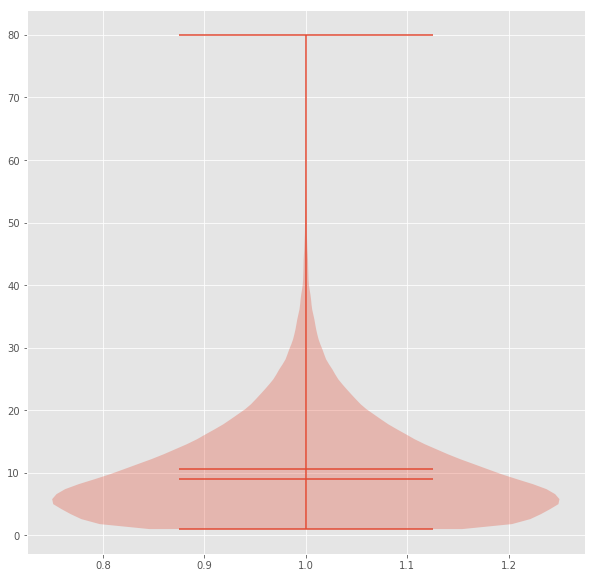

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
axes.violinplot(aco['add_to_cart_order'], showmeans=True, showmedians=True)

In [20]:
train_pivot = pd.pivot_table(order_products_train[order_products_train.order_id < 100], index='order_id', columns='product_id', values='add_to_cart_order')

In [21]:
train_pivot

product_id  329    790    1939   3880   4357   4461   7461   8859   9373   \
order_id                                                                    
1             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
36            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
38            NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN   
96            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
98           20.0   37.0   18.0   43.0    5.0    NaN   41.0    1.0   33.0   

product_id  9896   ...    46720  46979  47209  47333  47601  48287  48679  \
order_id           ...                                                      
1             NaN  ...      NaN    NaN    7.0    NaN    NaN    NaN    NaN   
36            NaN  ...      NaN    8.0    NaN    NaN    NaN    NaN    7.0   
38            NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96            NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
98           10.0  ...     35.0    NaN    NaN   26.0   14.0   27.0    NaN   

product_id  49235  49302  49683  
order_id                         
1             NaN    1.0    4.0  
36            3.0    NaN    NaN  
38            NaN    NaN    NaN  
96            NaN    NaN    NaN  
98            NaN    NaN    NaN  

[5 rows x 79 columns]

In [22]:
train_pivot.iloc[0][train_pivot.iloc[0].notnull()]

product_id
10246    3.0
11109    2.0
13176    6.0
22035    8.0
43633    5.0
47209    7.0
49302    1.0
49683    4.0
Name: 1, dtype: float64

In [23]:
train_pivot.iloc[1][train_pivot.iloc[1].notnull()]

product_id
19660    2.0
34497    6.0
39612    1.0
43086    4.0
46620    5.0
46979    8.0
48679    7.0
49235    3.0
Name: 36, dtype: float64

In [24]:
ot_sorted = order_products_train.sort_values('order_id')

In [25]:
ot_sorted[ot_sorted.order_id == 774]

order_id  product_id  add_to_cart_order  reordered
185       774       47482                  1          0
186       774       43335                  2          1
187       774       16108                  3          1

## Start building product_id recommendation basket.

In [26]:
training = ot_sorted

In [27]:
dict_of_product_id_in_cart = {}
for i,row in training.iterrows():
    current = row['order_id']
    if current not in dict_of_product_id_in_cart:
        dict_of_product_id_in_cart[current] = [row['product_id']]
    else:
        dict_of_product_id_in_cart[current].append(row['product_id'])
    

In [28]:
list_of_product_id_in_cart = list(dict_of_product_id_in_cart.values())

In [29]:
#print(dict_list)

# Follow code closely to see how to build dictionary with product_id key and product_id values related to how many times they appear together in carts.

In [30]:
product_id_matrix = {}
for p_ids in list_of_product_id_in_cart:
    for pid in p_ids:
        if pid not in product_id_matrix:
            count = 1
            product_id_matrix[pid] = {k:count for k in p_ids if k!=i}
        else:
            for i in p_ids:
                if i != pid:
                    if i in product_id_matrix[pid]:
                        product_id_matrix[pid][i] += count
                    else:
                        product_id_matrix[pid][i] = 1

                
                

        

### Checking to see if works for one product_id.

In [31]:
product_id_matrix[13176]

{1: 5,
 2: 1,
 3: 3,
 32772: 1,
 32773: 2,
 32776: 2,
 43692: 22,
 10: 13,
 5463: 9,
 32781: 14,
 32782: 11,
 15: 1,
 32784: 2,
 18: 1,
 32771: 1,
 23: 16,
 32792: 8,
 25: 23,
 28: 1,
 29: 1,
 32798: 1,
 32: 3,
 32801: 1,
 34: 53,
 35: 2,
 37: 2,
 32807: 1,
 41: 2,
 43: 1,
 44: 3,
 45: 80,
 5469: 1,
 49: 14,
 32818: 6,
 32819: 1,
 32820: 4,
 53: 4,
 32822: 3,
 32823: 1,
 32827: 3,
 32828: 14,
 32829: 1,
 32831: 12,
 32832: 3,
 65: 1,
 66: 2,
 32835: 1,
 32837: 1,
 70: 1,
 32839: 19,
 72: 1,
 74: 1,
 32843: 15,
 77: 1,
 32846: 3,
 79: 51,
 32850: 17,
 83: 4,
 32854: 6,
 10937: 1,
 32856: 1,
 32857: 18,
 93: 10,
 94: 6,
 95: 20,
 32864: 190,
 99: 7,
 100: 4,
 32869: 6,
 32873: 1,
 106: 8,
 108: 1,
 32877: 7,
 32880: 1,
 32881: 1,
 116: 28,
 117: 34,
 32888: 1,
 121: 1,
 122: 2,
 123: 6,
 124: 2,
 5482: 1,
 32895: 1,
 128: 12,
 43712: 28,
 130: 31,
 131: 2,
 32900: 1,
 32902: 2,
 32903: 1,
 32904: 6,
 32905: 9,
 32906: 3,
 16407: 2,
 141: 35,
 32911: 4,
 32912: 3,
 148: 20,
 149: 6,
 3291

In [181]:
#t = pd.DataFrame(product_id_matrix).to_sparse()

In [35]:
aco = order_products_train.groupby('order_id')

In [ ]:
#aco.head()

In [ ]:
aco.get_group(36)['product_id']

In [36]:
product.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [37]:
def whats_my_name(product_id):
    basket = []
    suggest = []
    new_dict = product_id_matrix[product_id]
    sorted_list = reversed(sorted(new_dict.items(), key=operator.itemgetter(1)))
    for item in sorted_list:
        basket.append(item)
    while len(basket) > 10:
        basket.pop()
    for item in basket:
        item = product.loc[product.product_id == item[0]]['product_name'].values[0]
        suggest.append(item)
    return suggest

In [38]:
product[product.product_name == 'Beer']

product_id product_name  aisle_id  department_id
46087       46088         Beer        27              5

In [39]:
whats_my_name(46088)

['India Pale Ale',
 'Banana',
 'Belgian White Wheat Ale',
 'Limes',
 '2% Reduced Fat Milk',
 'Small Hass Avocado',
 'Premium Belgian Lager',
 'Chardonnay',
 "Little Sumpin' Sumpin' Ale",
 'Cabernet Sauvignon']

In [40]:
msk = np.random.rand(len(order_products_train)) < 0.8
train = order_products_train[msk]
test = order_products_train[~msk]

In [ ]:
%%time
print(len(train))
print(len(test))

In [ ]:
random_df = product.sample(frac=1).reset_index(drop=True)
training_set = random_df.head(159000)
test_set = random_df.iloc[15901:].reset_index(drop=True)

In [41]:
def getval(d):
    return d[1]

In [43]:
def predictor(mat, item1, item2):
    recs = list(mat[item1].items()) + list(mat[item2].items())
    recs = sorted(recs, key=getval, reverse=True)
    recs = [recs[x][0] for x in range(min(5,len(recs)))]
    recs = list(set(recs))
    return recs

# Testing my predictions. (19%)

* Iterate over each order in the test set
    * use the first two items added to the order to make prediction.
    * compare the reccomend items with the items in the rest of the order.
    * If any in common get a point.
* Score = number of points / number of orders.

In [ ]:
test.head()

In [44]:
tco = test.groupby('order_id')

In [ ]:
hits = 0
count = 0
for order in tco.groups.keys():
    contents = list(tco.get_group(order).sort_values('add_to_cart_order').product_id)
    if len(contents) > 2:
        count += 1
        recs = predictor(product_id_matrix, contents[0], contents[1])
        basket = set(contents[3:])
        recs = set(recs)
        correct_recs = recs.intersection(basket)
        if len(correct_recs) >= 1:
            hits += 1
print(hits, count, hits/count)

In [62]:
print(predictor(product_id_matrix,12345,1213))

[21824, 49098, 24852, 47759, 46487]


In [63]:
for p in predictor(product_id_matrix,12345,1213):
    print(product[product.product_id == p].product_name)

21823    Single Slices American Cheese
Name: product_name, dtype: object
49097    Golden Sweet Potato
Name: product_name, dtype: object
24851    Banana
Name: product_name, dtype: object
47758    Mandarin Oranges
Name: product_name, dtype: object
46486    Sore Throat Plus Coating Protection Wild Berry...
Name: product_name, dtype: object


# AISLE_TO_AISLE MATRIX FOLLOWED BY FLOW GRAPH.

In [10]:
merge_prod_order = product.merge(order_products_train).sort_values(by='order_id').reset_index(drop=True)

In [11]:
new_flow = merge_prod_order.set_index(["order_id"]).reset_index()

In [12]:
grouped_object = new_flow.groupby('order_id')

In [32]:
grouped_object.get_group(1).sort_values(by='add_to_cart_order').reset_index(drop=True)

order_id  product_id                                   product_name  \
0         1       49302                               Bulgarian Yogurt   
1         1       11109  Organic 4% Milk Fat Whole Milk Cottage Cheese   
2         1       10246                          Organic Celery Hearts   
3         1       49683                                 Cucumber Kirby   
4         1       43633           Lightly Smoked Sardines in Olive Oil   
5         1       13176                         Bag of Organic Bananas   
6         1       47209                           Organic Hass Avocado   
7         1       22035                    Organic Whole String Cheese   

   aisle_id  department_id  add_to_cart_order  reordered  
0       120             16                  1          1  
1       108             16                  2          1  
2        83              4                  3          0  
3        83              4                  4          0  
4        95             15                  5          1  
5        24              4                  6          0  
6        24              4                  7          0  
7        21             16                  8          1

# This creates an aisle2aisle matrix.

In [13]:
%%time
aisles_to_aisles = {}
for i in list(set(new_flow.order_id)):
    
    # get group by object for a given order_id. Sort by add_to_cart_order.
    grouped_object_df = grouped_object.get_group(i).sort_values(by='add_to_cart_order').reset_index(drop=True)
    
    # create a list for the path of aisles within a given order_id.
    aisles_list = list(grouped_object_df.aisle_id)#grouped_object.get_group(i).sort_values(by='add_to_cart_order').reset_index(drop=True).aisle_id)
    
    #creates the matrix.
    for item in list(zip(aisles_list,aisles_list[1:])):
        if item[0] not in aisles_to_aisles:
            aisles_to_aisles[item[0]] = {item[1]:1}
        else:
            if item[1] not in aisles_to_aisles[item[0]]:
                aisles_to_aisles[item[0]][item[1]] = 1
            else:
                aisles_to_aisles[item[0]][item[1]] += 1

CPU times: user 2min 20s, sys: 464 ms, total: 2min 21s
Wall time: 2min 20s


In [191]:
aisles_to_aisles

{1: {1: 188,
  2: 12,
  3: 23,
  4: 18,
  5: 6,
  6: 2,
  7: 4,
  8: 4,
  9: 21,
  10: 1,
  12: 4,
  13: 52,
  14: 7,
  15: 5,
  16: 13,
  17: 8,
  18: 1,
  19: 15,
  20: 3,
  21: 78,
  23: 16,
  24: 213,
  25: 2,
  26: 20,
  27: 5,
  28: 1,
  29: 4,
  30: 2,
  31: 48,
  32: 26,
  33: 1,
  34: 7,
  35: 8,
  36: 11,
  37: 53,
  38: 42,
  39: 4,
  41: 3,
  42: 5,
  43: 8,
  45: 27,
  46: 2,
  47: 5,
  48: 3,
  49: 11,
  50: 8,
  51: 9,
  52: 16,
  53: 16,
  54: 21,
  57: 7,
  58: 2,
  59: 32,
  60: 2,
  61: 14,
  62: 2,
  63: 2,
  64: 3,
  65: 3,
  66: 12,
  67: 47,
  69: 74,
  70: 1,
  71: 7,
  72: 12,
  73: 1,
  74: 5,
  75: 4,
  77: 27,
  78: 58,
  79: 16,
  81: 11,
  83: 168,
  84: 61,
  85: 3,
  86: 34,
  87: 3,
  88: 19,
  89: 16,
  90: 1,
  91: 36,
  92: 12,
  93: 20,
  94: 18,
  95: 11,
  96: 50,
  97: 2,
  98: 29,
  99: 5,
  100: 34,
  101: 2,
  104: 5,
  105: 8,
  106: 27,
  107: 47,
  108: 19,
  109: 1,
  110: 15,
  111: 1,
  112: 55,
  114: 1,
  115: 46,
  116: 36,
  117: 19,

In [17]:
trying = pd.DataFrame(aisles_to_aisles).fillna(0)

In [23]:
trying.head()

1      2       3       4     5     6     7     8      9    10  ...   \
1  188.0    5.0    34.0    21.0   6.0   6.0   4.0   7.0   16.0  0.0 ...    
2   12.0  134.0    23.0    21.0   6.0   2.0   9.0   3.0   44.0  2.0 ...    
3   23.0   19.0  4483.0    85.0  13.0  17.0   8.0  13.0   75.0  0.0 ...    
4   18.0   28.0    78.0  1164.0  41.0  11.0  17.0  10.0  116.0  3.0 ...    
5    6.0   12.0    21.0    42.0  91.0   5.0   6.0   2.0   41.0  2.0 ...    

    125   126   127   128    129   130    131  132  133  134  
1   2.0   2.0   1.0  16.0   19.0  15.0   12.0  0.0  1.0  0.0  
2   2.0   0.0   2.0  28.0   24.0   8.0   55.0  1.0  2.0  2.0  
3  44.0  11.0  11.0  41.0   67.0  76.0   59.0  1.0  5.0  0.0  
4  10.0   7.0  13.0  52.0  110.0  45.0  132.0  1.0  9.0  1.0  
5   0.0   0.0   2.0  24.0   31.0  10.0   25.0  0.0  2.0  0.0  

[5 rows x 134 columns]

In [37]:
trying[(trying.T > -1.14).all()]   

1      2      3      4      5      6      7      8      9      10   \
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
5    False  False  False  False  False  False  False  False  False  False   
6    False  False  False  False  False  False  False  False  False  False   
7    False  False  False  False  False  False  False  False  False  False   
8    False  False  False  False  False  False  False  False  False  False   
9    False  False  False  False  False  False  False  False  False  False   
10   False  False  False  False  False  False  False  False  False  False   
11   False  False  False  False  False  False  False  False  False  False   
12   False  False  False  False  False  False  False  False  False  False   
13   False  False  False  False  False  False  False  False  False  False   
14   False  False  False  False  False  False  False  False  False  False   
15   False  False  False  False  False  False  False  False  False  False   
16   False  False  False  False  False  False  False  False  False  False   
17   False  False  False  False  False  False  False  False  False  False   
18   False  False  False  False  False  False  False  False  False  False   
19   False  False  False  False  False  False  False  False  False  False   
20   False  False  False  False  False  False  False  False  False  False   
21   False  False  False  False  False  False  False  False  False  False   
22   False  False  False  False  False  False  False  False  False  False   
23   False  False  False  False  False  False  False  False  False  False   
24   False  False  False  False  False  False  False  False  False  False   
25   False  False  False  False  False  False  False  False  False  False   
26   False  False  False  False  False  False  False  False  False  False   
27   False  False  False  False  False  False  False  False  False  False   
28   False  False  False  False  False  False  False  False  False  False   
29   False  False  False  False  False  False  False  False  False  False   
30   False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
105  False  False  False  False  False  False  False  False  False  False   
106  False  False  False  False  False  False  False  False  False  False   
107  False  False  False  False  False  False  False  False  False  False   
108  False  False  False  False  False  False  False  False  False  False   
109  False  False  False  False  False  False  False  False  False  False   
110  False  False  False  False  False  False  False  False  False  False   
111  False  False  False  False  False  False  False  False  False  False   
112  False  False  False  False  False  False  False  False  False  False   
113  False  False  False  False  False  False  False  False  False  False   
114  False  False  False  False  False  False  False  False  False  False   
115  False  False  False  False  False  False  False  False  False  False   
116  False  False  False  False  False  False  False  False  False  False   
117  False  False  False  False  False  False  False  False  False  False   
118  False  False  False  False  False  False  False  False  False  False   
119  False  False  False  False  False  False  False  False  False  False   
120  False  False  False  False  False  False  False  False  False  False   
121  False  False  False  False  False  False  False  False  False  False   
122  False  False  False  False  False  False  False  False  False  False   
123  False  False  False  False  False  False  False  False  False  False   
124  False  False  False  False  False  False  False  False  False  False   
125

# Blob Heat Map, ugh. Chord diagram next?

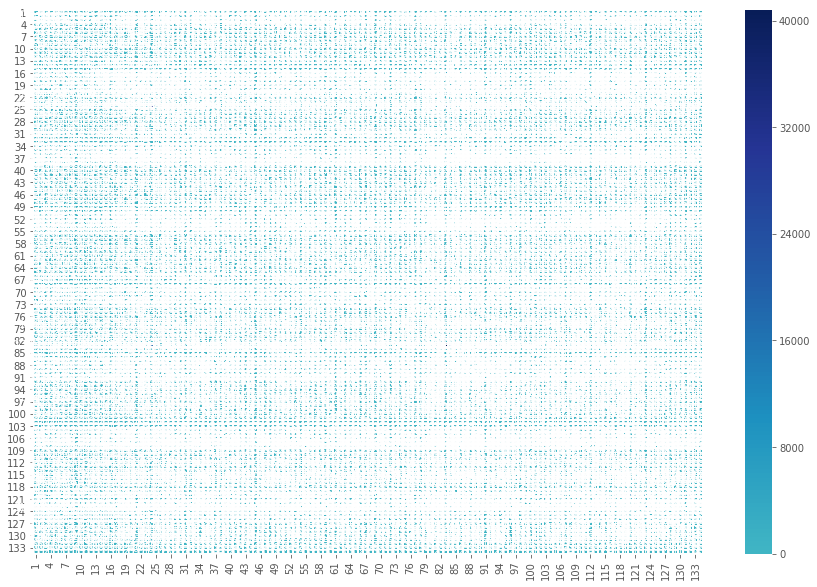

In [16]:
a4_dims = (15, 10)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sbn.heatmap(trying, vmin=0,center=0, annot=True, linewidths=.5, cmap="YlGnBu")

# Network graph maybe?

In [18]:
g = nx.DiGraph()
g.add_nodes_from(trying)

#for index, row in new_df.iterrows():
#    g.add_edge(row['abbv'], row['relation'])

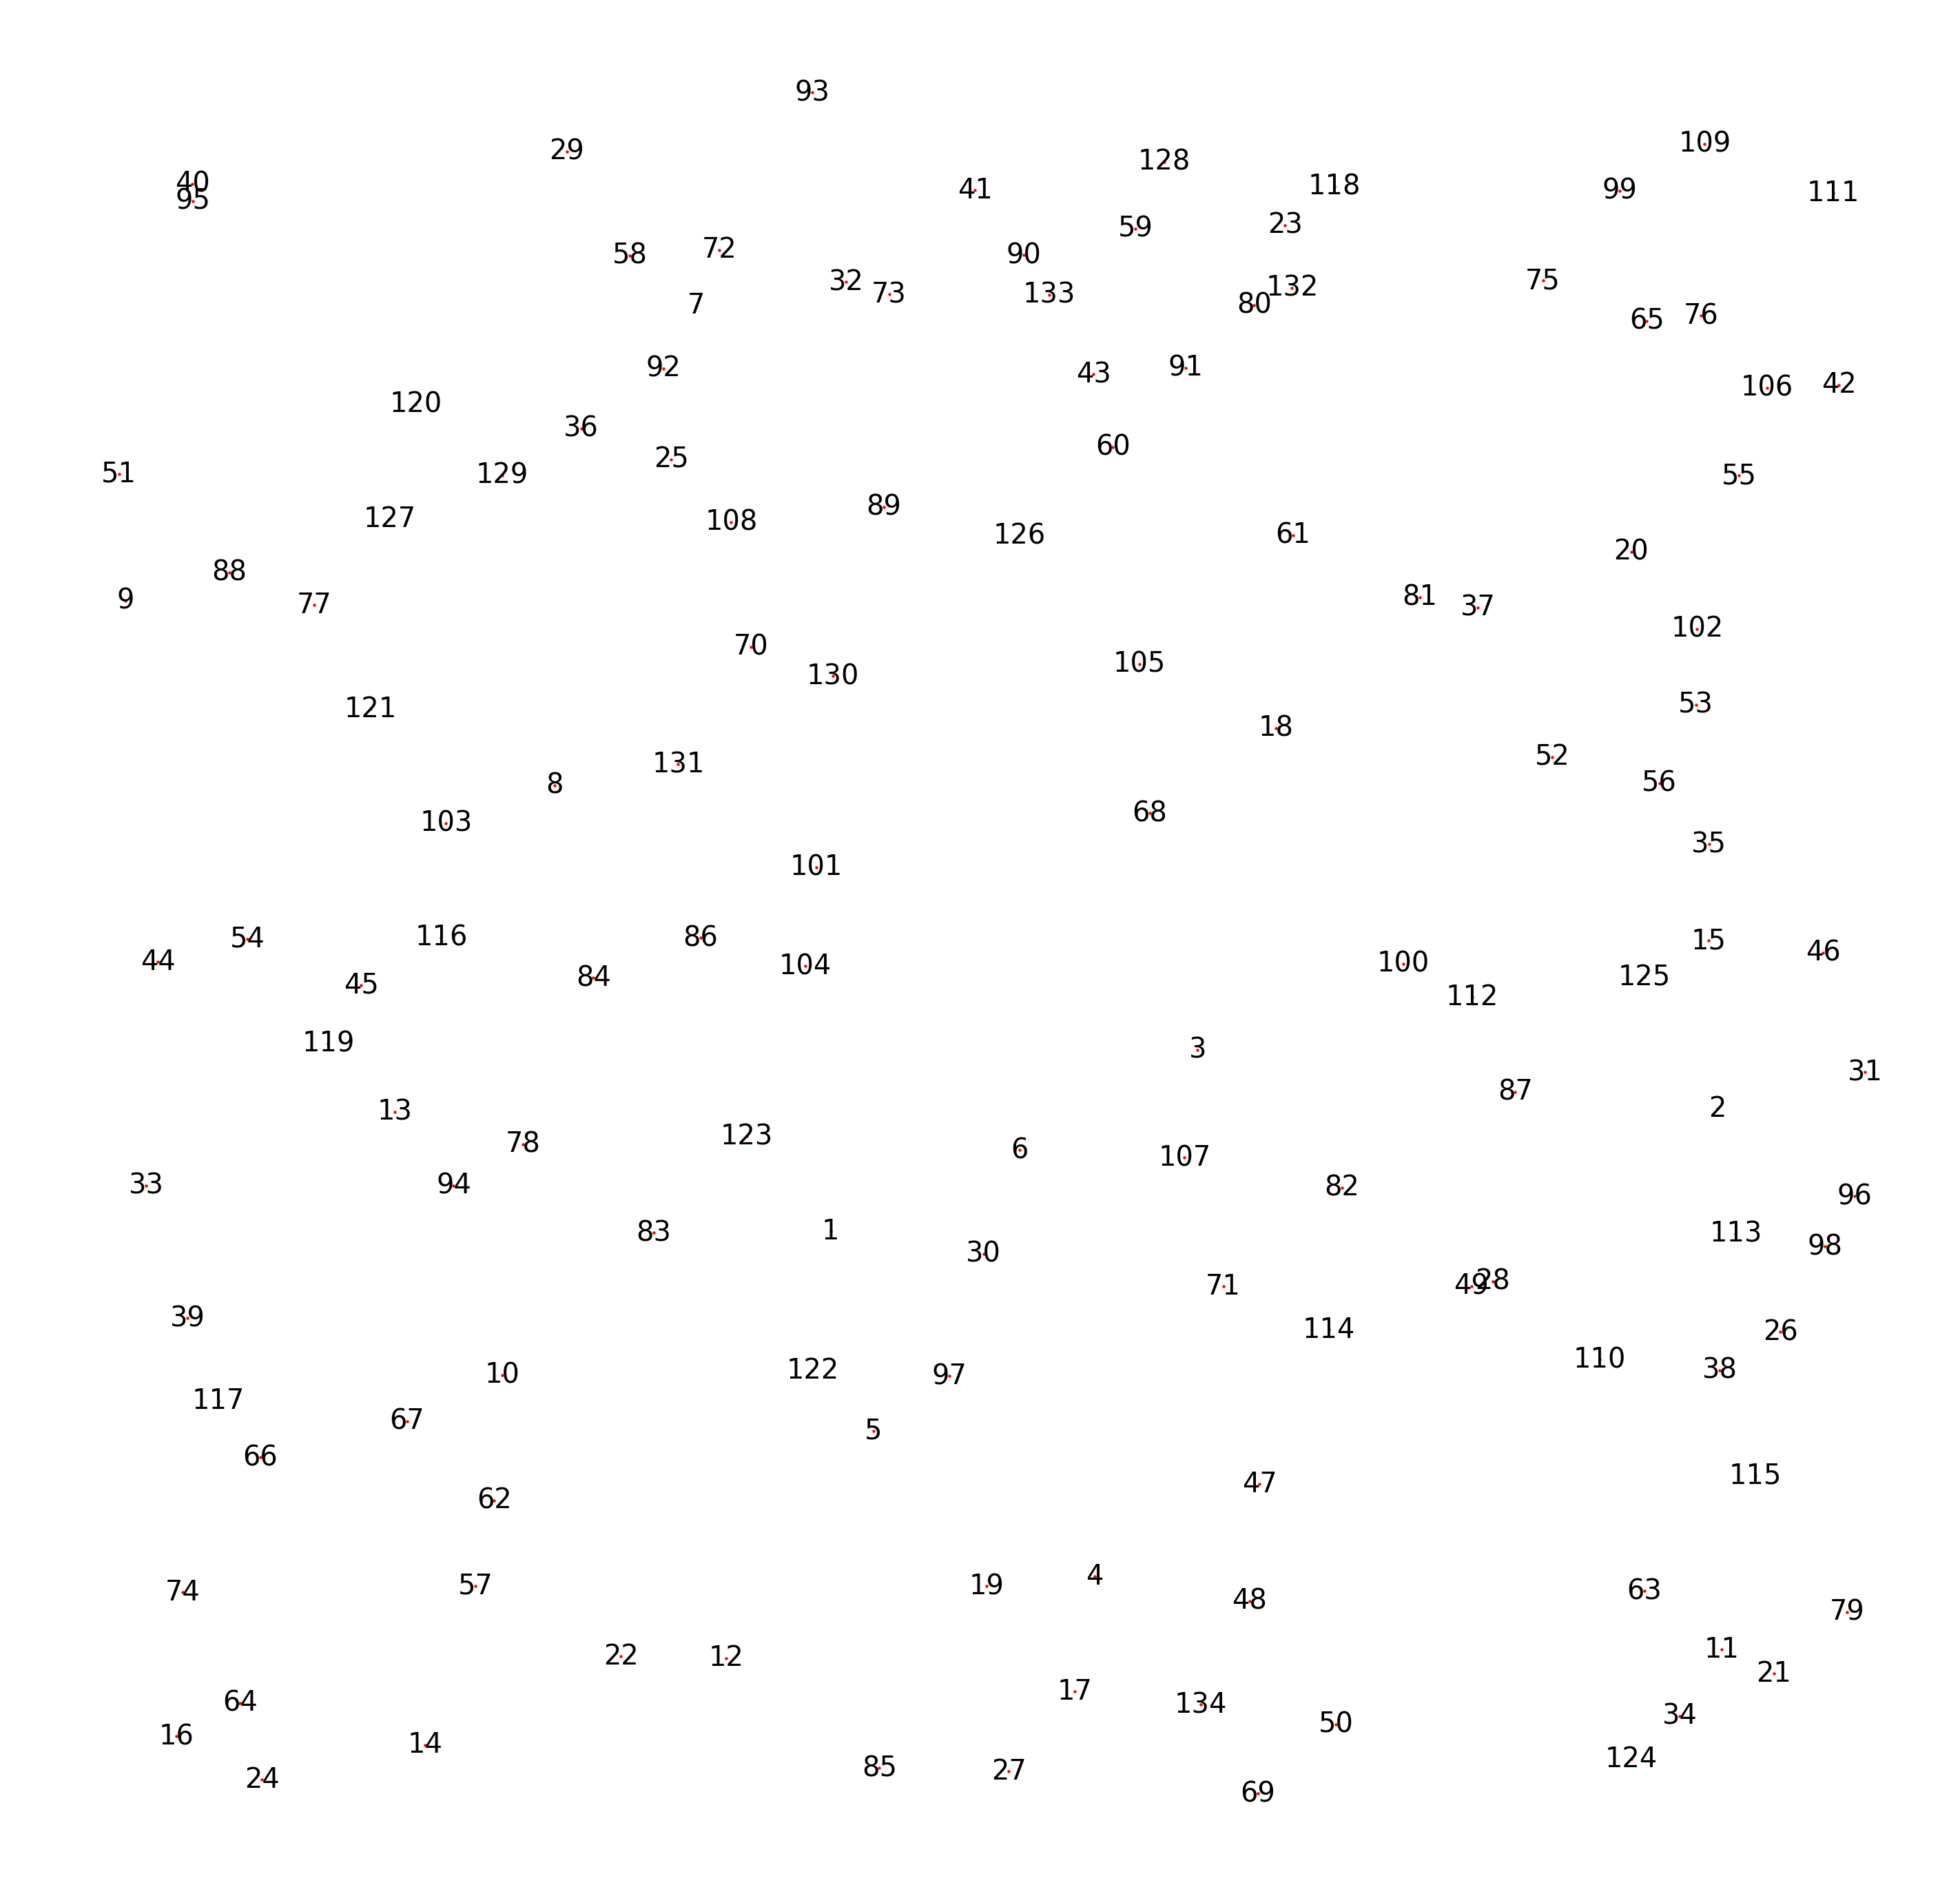

In [21]:
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 40, node_size = 15)